In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from itertools import islice
import time
import matplotlib.pyplot as plt

batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

### LeNet

Точность без обучения: 9.58%
SGD:
Эпоха: 1, Потери: 0.007996086129639297
Эпоха: 2, Потери: 0.0014872237949554497
Эпоха: 3, Потери: 0.0009864526957118263
Эпоха: 4, Потери: 0.0007834698993994001
Эпоха: 5, Потери: 0.0006362831767648459
Точность SGD: 98.53%
Время обучения: 130.01401233673096 с

AdaDelta:
Эпоха: 1, Потери: 0.0037633501335745676
Эпоха: 2, Потери: 0.0009206200357817579
Эпоха: 3, Потери: 0.0006636966690949824
Эпоха: 4, Потери: 0.0005271021408615828
Эпоха: 5, Потери: 0.0004285806951976459
Точность AdaDelta: 98.79%
Время обучения: 122.47829174995422 с

NAG:
Эпоха: 1, Потери: 0.00847999047661821
Эпоха: 2, Потери: 0.0015371000837689887
Эпоха: 3, Потери: 0.0010297600048710593
Эпоха: 4, Потери: 0.000796240697944692
Эпоха: 5, Потери: 0.0006468107170241031
Точность NAG: 98.39%
Время обучения: 113.68017983436584 с

Adam:
Эпоха: 1, Потери: 0.0028273094981675967
Эпоха: 2, Потери: 0.0009510956179486432
Эпоха: 3, Потери: 0.000756701152009191
Эпоха: 4, Потери: 0.0006551825891707267
Эпоха: 5

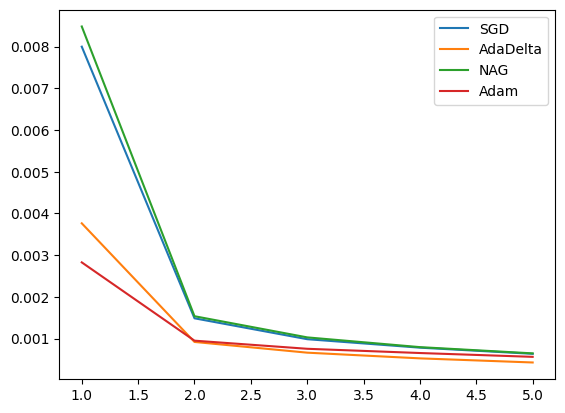

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net0 = LeNet().to(device)
net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()

def resetNet():
    net.load_state_dict(net0.state_dict())

def countAccuracy():
    correct = 0
    size = len(testloader)
    for image, label in islice(testloader, size):
        image, label = image.to(device), label.to(device)
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item()
    return 100 * correct / len(testset)

def train(optimizer, optim_name):
    print(f"{optim_name}:")
    start_time = time.time()
    xs, ys = [], []
    batch_num = len(trainloader)
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in islice(trainloader, batch_num):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        xs.append(epoch + 1)
        ys.append(running_loss / len(trainset))
        print(f'Эпоха: {xs[-1]}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = optim_name)
    print(f"Точность {optim_name}: {countAccuracy():.2f}%")
    print(f"Время обучения: {time.time() - start_time} с\n")

resetNet()
print(f"Точность без обучения: {countAccuracy():.2f}%")
SGD = optim.SGD(net.parameters(), lr=0.1)
train(SGD, "SGD")
resetNet()
AdaDelta = optim.Adadelta(net.parameters(), lr=1.0)
train(AdaDelta, "AdaDelta")
resetNet()
NAG = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)
train(NAG, "NAG")
resetNet()
Adam = optim.Adam(net.parameters(), lr=0.005)
train(Adam, "Adam")

plt.legend()
plt.show()

In [3]:
print(torch.cuda.is_available())

True
